In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)
2016-08-23


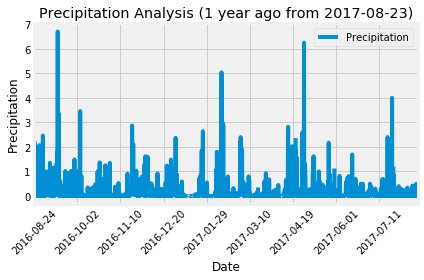

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [10]:
# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)
#week_ago = dt.date.today() - dt.timedelta(days=7)
one_year_ago=dt.date(2017,8,23) -dt.timedelta(days=365)
#one_year_ago=dt.date(latest_date,'%y-%m-%d') -dt.timedelta(days=365)

print(one_year_ago)
# Perform a query to retrieve the data and precipitation scores
prec_date =session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date <= '2017-08-23').filter(Measurement.date>'2016-08-23').order_by(Measurement.date).all() 

#for d in prec_date:
#       print(d)
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prec_date, columns=['date','prcp'])
#df.dropna()
df.set_index('date').head()
#df.head()
 # Use Pandas Plotting with Matplotlib to plot the data
df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation Analysis (1 year ago from 2017-08-23)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
# Save an image of the chart and print it to the screen
plt.savefig("Images/Precipitation Analysis.png")
plt.show()
df.describe()

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
station_no=session.query(Measurement).group_by(Measurement.station).count()
print(station_no)

9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                   order_by(func.count(Measurement.station).desc()).all()
print(active_station)
active_sttion_df = pd.DataFrame(active_station, columns=['station', 'count'])
active_sttion_df

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = session.query(Measurement.station,Station.name,func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                   order_by(func.count(Measurement.station).desc()).first()
print(most_active_station)

('USC00519281', 'WAIKIKI 717.2, HI US', 24948)


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_tob = session.query(Measurement.station, Measurement.tobs).\
            filter(Measurement.station == 'USC00519281').\
            filter(Measurement.date>=one_year_ago).\
            order_by(Measurement.date).all()
max_tob_df=pd.DataFrame(max_tob)
max_tob_df.head()


,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


In [17]:
all_temp = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.date >= one_year_ago).all()
all_temp

[(58.0, 74.59058295964125, 87.0)]

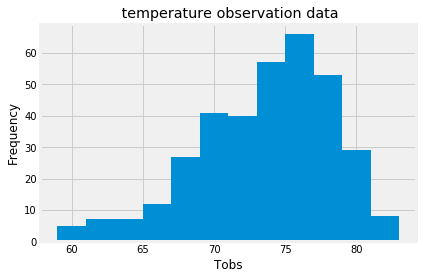

In [18]:
plt.hist(max_tob_df['tobs'],12)
plt.xlabel("Tobs")
plt.ylabel("Frequency")
plt.title(" temperature observation data")
plt.show()

![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_pre_year = calc_temps('2011-02-28', '2011-03-05')
temp_pre_year


[(61.0, 69.75510204081633, 75.0)]

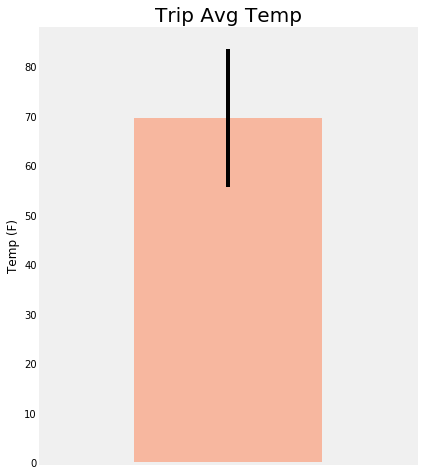

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(temp_pre_year, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
